'/kaggle/working'

In [17]:
ls /kaggle/input/viton-hd-dataset

test/  test_pairs.txt*  train/  train_pairs.txt*


In [18]:
!git clone -b CatVTON https://github.com/Harsh-Kesharwani/stable-diffusion.git

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 150 (delta 36), reused 139 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (150/150), 9.11 MiB | 20.74 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [19]:
cd stable-diffusion/

/kaggle/working/stable-diffusion


In [20]:
!wget https://huggingface.co/sd-legacy/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt

--2025-06-13 07:07:34--  https://huggingface.co/sd-legacy/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt
Resolving huggingface.co (huggingface.co)... 18.67.93.22, 18.67.93.63, 18.67.93.58, ...
Connecting to huggingface.co (huggingface.co)|18.67.93.22|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /stable-diffusion-v1-5/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt [following]
--2025-06-13 07:07:34--  https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/f6/56/f656f0fa3b8a40ac76d297fa2a4b00f981e8eb1261963460764e7dd3b35ec97f/c6bbc15e3224e6973459ba78de4998b80b50112b0ae5b5c67113d56b4e366b19?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sd-v1-5-inpainting.ckpt%3B+filename%3D%22sd-v1-5-inpainting.ckpt%22

In [ ]:
# !wget https://huggingface.co/zhengchong/CatVTON/resolve/main/vitonhd-16k-512/attention/model.safetensors?download=true 

--2025-06-11 10:33:19--  https://huggingface.co/zhengchong/CatVTON/resolve/main/vitonhd-16k-512/attention/model.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 3.163.189.37, 3.163.189.90, 3.163.189.114, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/49/48/4948d897acaa287a14cc261fb60bfdb3ff0e6571ca16a0b5fa38cec3cfebdc34/915df7bf19a33bee36a28d5f9ceaef1e2267c47526f98ca9e4c49e90ae5f0fd0?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1749641599&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0OTY0MTU5OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzQ5LzQ4LzQ5NDhkODk3YWNhYTI4N2ExNGNjMjYxZmI2MGJmZGIzZmYwZTY1NzFjYTE2YTBiNWZhMzhjZWMzY2ZlYmRjMzQvOTE1ZGY3YmYxOWEzM2JlZTM2YTI4ZDVmOWNlYWVmMWUyMjY3YzQ3NTI2Zjk4

In [11]:
mv 'model.safetensors?download=true' model.safetensors

In [12]:
!ls

attention.py  encoder.py	  model.safetensors  sd-v1-5-inpainting.ckpt
clip.py       interface.py	  pipeline.py	     test.ipynb
ddpm.py       merges.txt	  README.md	     vocab.json
decoder.py    model_converter.py  requirements.txt
diffusion.py  model.py		  sample_dataset


In [14]:
cd ..

/kaggle/working/stable-diffusion/CatVTON


In [15]:
ls

app_flux.py  eval.py       preprocess_agnostic_mask.py  stable-diffusion/
app_p2p.py   index.html    __pycache__/                 utils.py
app.py       inference.py  README.md
densepose/   LICENSE       requirements.txt
detectron2/  model/        resource/


In [16]:
import os
import shutil

src_dir = "./stable-diffusion"
dst_dir = "."

for filename in os.listdir(src_dir):
    src_path = os.path.join(src_dir, filename)
    dst_path = os.path.join(dst_dir, filename)
    if os.path.isfile(src_path):
        shutil.move(src_path, dst_path)
    elif os.path.isdir(src_path):
        shutil.move(src_path, dst_path)

In [229]:
import torch
import gc

# Clear CUDA cache and collect garbage
torch.cuda.empty_cache()
gc.collect()

# Delete all user-defined variables except for built-ins and modules
for var in list(globals()):
    if not var.startswith("__") and var not in ["torch", "gc"]:
        del globals()[var]

gc.collect()
torch.cuda.empty_cache()

In [245]:
import torch
import gc

# Clear CUDA cache and collect garbage
torch.cuda.empty_cache()
gc.collect()

# Delete all user-defined variables except for built-ins and modules
for var_name in list(globals()):
    if not var_name.startswith("__") and var_name not in ["torch", "gc"]:
        del globals()[var_name]

gc.collect()
torch.cuda.empty_cache()

import tensorflow as tf
tf.keras.backend.clear_session()

In [4]:
import torch
import gc

torch.cuda.empty_cache()  # Release unused GPU memory
gc.collect()              # Run Python garbage collector

0

In [9]:
import torch

if torch.cuda.is_available():
    used = torch.cuda.memory_allocated() / 1024 ** 2  # in MB
    total = torch.cuda.get_device_properties(0).total_memory / 1024 ** 2  # in MB
    print(f"GPU memory used: {used:.2f} MB / {total:.2f} MB")
else:
    print("CUDA is not available.")

GPU memory used: 0.00 MB / 16269.25 MB


In [197]:
# rm -rf output

In [ ]:
def compute_vae_encodings(image_tensor, encoder, device="cuda"):
    """Encode image using VAE encoder"""
    # Generate random noise for encoding
    encoder_noise = torch.randn(
        (image_tensor.shape[0], 4, image_tensor.shape[2] // 8, image_tensor.shape[3] // 8),
        device=device,
    )
    
    # Encode using your custom encoder
    latent = encoder(image_tensor, encoder_noise)
    return latent

In [ ]:
def get_trainable_module(unet, trainable_module_name):
    if trainable_module_name == "unet":
        return unet
    elif trainable_module_name == "transformer":
        trainable_modules = torch.nn.ModuleList()
        for blocks in [unet.encoders, unet.bottleneck, unet.decoders]:
            if hasattr(blocks, "attentions"):
                trainable_modules.append(blocks.attentions)
            else:
                for block in blocks:
                    if hasattr(block, "attentions"):
                        trainable_modules.append(block.attentions)
        return trainable_modules
    elif trainable_module_name == "attention":
        attn_blocks = torch.nn.ModuleList()
        for name, param in unet.named_modules():
            if "attention_1" in name:
                attn_blocks.append(param)
        return attn_blocks
    else:
        raise ValueError(f"Unknown trainable_module_name: {trainable_module_name}")

In [ ]:
from torch.nn import functional as F
import torch
# from flash_attn import flash_attn_func

class SkipAttnProcessor(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()

    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
    ):
        return hidden_states

class AttnProcessor2_0(torch.nn.Module):
    r"""
    Processor for implementing scaled dot-product attention (enabled by default if you're using PyTorch 2.0).
    """

    def __init__(
        self,
        hidden_size=None,
        cross_attention_dim=None,
        **kwargs
    ):
        super().__init__()
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("AttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")

    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
        *args,
        **kwargs,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        # the output of sdp = (batch, num_heads, seq_len, head_dim)
        # TODO: add support for attn.scale when we move to Torch 2.1
        
        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )
        # hidden_states = flash_attn_func(
        #     query, key, value, dropout_p=0.0, causal=False
        # )

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states
   

In [ ]:
import os
import json
import torch

def init_adapter(unet, 
                 cross_attn_cls=SkipAttnProcessor,
                 self_attn_cls=None,
                 cross_attn_dim=None, 
                 **kwargs):
    if cross_attn_dim is None:
        cross_attn_dim = unet.config.cross_attention_dim
    attn_procs = {}
    for name in unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else cross_attn_dim
        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]
        if cross_attention_dim is None:
            if self_attn_cls is not None:
                attn_procs[name] = self_attn_cls(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, **kwargs)
            else:
                # retain the original attn processor
                attn_procs[name] = AttnProcessor2_0(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, **kwargs)
        else:
            attn_procs[name] = cross_attn_cls(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, **kwargs)
                                                    
    unet.set_attn_processor(attn_procs)
    adapter_modules = torch.nn.ModuleList(unet.attn_processors.values())
    return adapter_modules

def init_diffusion_model(diffusion_model_name_or_path, unet_class=None):
    from diffusers import AutoencoderKL
    from transformers import CLIPTextModel, CLIPTokenizer

    text_encoder = CLIPTextModel.from_pretrained(diffusion_model_name_or_path, subfolder="text_encoder")
    vae = AutoencoderKL.from_pretrained(diffusion_model_name_or_path, subfolder="vae")
    tokenizer = CLIPTokenizer.from_pretrained(diffusion_model_name_or_path, subfolder="tokenizer")
    try:
        unet_folder = os.path.join(diffusion_model_name_or_path, "unet")
        unet_configs = json.load(open(os.path.join(unet_folder, "config.json"), "r"))
        unet = unet_class(**unet_configs)
        unet.load_state_dict(torch.load(os.path.join(unet_folder, "diffusion_pytorch_model.bin"), map_location="cpu"), strict=True)
    except:
        unet = None
    return text_encoder, vae, tokenizer, unet

def attn_of_unet(unet):
    attn_blocks = torch.nn.ModuleList()
    for name, param in unet.named_modules():
        if "attn1" in name:
            attn_blocks.append(param)
    return attn_blocks

def get_trainable_module(unet, trainable_module_name):
    if trainable_module_name == "unet":
        return unet
    elif trainable_module_name == "transformer":
        trainable_modules = torch.nn.ModuleList()
        for blocks in [unet.down_blocks, unet.mid_block, unet.up_blocks]:
            if hasattr(blocks, "attentions"):
                trainable_modules.append(blocks.attentions)
            else:
                for block in blocks:
                    if hasattr(block, "attentions"):
                        trainable_modules.append(block.attentions)
        return trainable_modules
    elif trainable_module_name == "attention":
        attn_blocks = torch.nn.ModuleList()
        for name, param in unet.named_modules():
            if "attn1" in name:
                attn_blocks.append(param)
        return attn_blocks
    else:
        raise ValueError(f"Unknown trainable_module_name: {trainable_module_name}")

                
    

In [ ]:
import inspect
import os
from typing import Union

import PIL
import numpy as np
import torch
import tqdm
from accelerate import load_checkpoint_in_model
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion.safety_checker import \
    StableDiffusionSafetyChecker
from diffusers.utils.torch_utils import randn_tensor
from huggingface_hub import snapshot_download
from transformers import CLIPImageProcessor

from utils import (check_inputs, get_time_embedding, numpy_to_pil, prepare_image,
                   prepare_mask_image, resize_and_crop, resize_and_padding)
from ddpm import DDPMSampler

class CatVTONPipeline:
    def __init__(
        self, 
        base_ckpt, 
        attn_ckpt, 
        attn_ckpt_version="mix",
        weight_dtype=torch.float32,
        device='cuda',
        compile=False,
        skip_safety_check=True,
        use_tf32=True,
        models={},
    ):
        self.device = device
        self.weight_dtype = weight_dtype
        self.skip_safety_check = skip_safety_check
        self.models = models

        self.generator = torch.Generator(device=device)
        self.noise_scheduler = DDPMSampler(generator=self.generator)
        # self.vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device, dtype=weight_dtype)
        self.encoder= models.get('encoder', None)
        self.decoder= models.get('decoder', None)
        if not skip_safety_check:
            self.feature_extractor = CLIPImageProcessor.from_pretrained(base_ckpt, subfolder="feature_extractor")
            self.safety_checker = StableDiffusionSafetyChecker.from_pretrained(base_ckpt, subfolder="safety_checker").to(device, dtype=weight_dtype)
        self.unet = UNet2DConditionModel.from_pretrained(base_ckpt, subfolder="unet").to(device, dtype=weight_dtype)
        # self.unet=models.get('diffusion', None)
        init_adapter(self.unet, cross_attn_cls=SkipAttnProcessor)  # Skip Cross-Attention
        self.attn_modules = get_trainable_module(self.unet, "attention")
        self.auto_attn_ckpt_load(attn_ckpt, attn_ckpt_version)
        # Pytorch 2.0 Compile
        # if compile:
        #     self.unet = torch.compile(self.unet)
        #     self.vae = torch.compile(self.vae, mode="reduce-overhead")
            
        # # Enable TF32 for faster training on Ampere GPUs (A100 and RTX 30 series).
        if use_tf32:
            torch.set_float32_matmul_precision("high")
            torch.backends.cuda.matmul.allow_tf32 = True

    def auto_attn_ckpt_load(self, attn_ckpt, version):
        sub_folder = {
            "mix": "mix-48k-1024",
            "vitonhd": "vitonhd-16k-512",
            "dresscode": "dresscode-16k-512",
        }[version]
        if os.path.exists(attn_ckpt):
            load_checkpoint_in_model(self.attn_modules, os.path.join(attn_ckpt, sub_folder, 'attention'))
        else:
            repo_path = snapshot_download(repo_id=attn_ckpt)
            print(f"Downloaded {attn_ckpt} to {repo_path}")
            load_checkpoint_in_model(self.attn_modules, os.path.join(repo_path, sub_folder, 'attention'))
            
    def run_safety_checker(self, image):
        if self.safety_checker is None:
            has_nsfw_concept = None
        else:
            safety_checker_input = self.feature_extractor(image, return_tensors="pt").to(self.device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(self.weight_dtype)
            )
        return image, has_nsfw_concept
    
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(
            inspect.signature(self.noise_scheduler.step).parameters.keys()
        )
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(
            inspect.signature(self.noise_scheduler.step).parameters.keys()
        )
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    @torch.no_grad()
    def __call__(
        self, 
        image: Union[PIL.Image.Image, torch.Tensor],
        condition_image: Union[PIL.Image.Image, torch.Tensor],
        mask: Union[PIL.Image.Image, torch.Tensor],
        num_inference_steps: int = 50,
        guidance_scale: float = 2.5,
        height: int = 1024,
        width: int = 768,
        generator=None,
        eta=1.0,
        **kwargs
    ):
        concat_dim = -2  # FIXME: y axis concat
        # Prepare inputs to Tensor
        image, condition_image, mask = check_inputs(image, condition_image, mask, width, height)
        image = prepare_image(image).to(self.device, dtype=self.weight_dtype)
        condition_image = prepare_image(condition_image).to(self.device, dtype=self.weight_dtype)
        mask = prepare_mask_image(mask).to(self.device, dtype=self.weight_dtype)
        # Mask image
        masked_image = image * (mask < 0.5)
        # VAE encoding
        masked_latent = compute_vae_encodings(masked_image, self.encoder)
        condition_latent = compute_vae_encodings(condition_image, self.encoder)
        mask_latent = torch.nn.functional.interpolate(mask, size=masked_latent.shape[-2:], mode="nearest")
        del image, mask, condition_image
        # Concatenate latents
        masked_latent_concat = torch.cat([masked_latent, condition_latent], dim=concat_dim)
        mask_latent_concat = torch.cat([mask_latent, torch.zeros_like(mask_latent)], dim=concat_dim)
        # Prepare noise
        latents = randn_tensor(
            masked_latent_concat.shape,
            generator=generator,
            device=masked_latent_concat.device,
            dtype=self.weight_dtype,
        )
        # Prepare timesteps
        self.noise_scheduler.set_inference_timesteps(num_inference_steps)
        timesteps = self.noise_scheduler.timesteps
        # latents = latents * self.noise_scheduler.init_noise_sigma
        latents = self.noise_scheduler.add_noise(latents, timesteps[0])
        # Classifier-Free Guidance
        if do_classifier_free_guidance := (guidance_scale > 1.0):
            masked_latent_concat = torch.cat(
                [
                    torch.cat([masked_latent, torch.zeros_like(condition_latent)], dim=concat_dim),
                    masked_latent_concat,
                ]
            )
            mask_latent_concat = torch.cat([mask_latent_concat] * 2)

        # Denoising loop
        # extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)
        # num_warmup_steps = (len(timesteps) - num_inference_steps * self.noise_scheduler.order)
        num_warmup_steps = 0  # For simple DDPM, no warmup needed
        with tqdm(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                non_inpainting_latent_model_input = (torch.cat([latents] * 2) if do_classifier_free_guidance else latents)
                # non_inpainting_latent_model_input = self.noise_scheduler.scale_model_input(non_inpainting_latent_model_input, t)
                # prepare the input for the inpainting model
                inpainting_latent_model_input = torch.cat([non_inpainting_latent_model_input, mask_latent_concat, masked_latent_concat], dim=1).to(self.device, dtype=self.weight_dtype)
                # predict the noise residual
                # time_embedding = get_time_embedding(t.item())
                # time_embedding = time_embedding.repeat(inpainting_latent_model_input.shape[0], 1).to(self.device, dtype=self.weight_dtype)
                noise_pred= self.unet(
                    inpainting_latent_model_input,
                    # time_embedding
                    t.to(self.device),
                    encoder_hidden_states=None, # FIXME
                    return_dict=False,
                )[0]
                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (
                        noise_pred_text - noise_pred_uncond
                    )
                # compute the previous noisy sample x_t -> x_t-1
                latents = self.noise_scheduler.step(
                    t, latents, noise_pred
                )
                # call the callback, if provided
                if i == len(timesteps) - 1 or (
                    (i + 1) > num_warmup_steps
                ):
                    progress_bar.update()

        # Decode the final latents
        latents = latents.split(latents.shape[concat_dim] // 2, dim=concat_dim)[0]
        # latents = 1 / self.vae.config.scaling_factor * latents
        # image = self.vae.decode(latents.to(self.device, dtype=self.weight_dtype)).sample
        image = self.decoder(latents.to(self.device, dtype=self.weight_dtype))
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        image = numpy_to_pil(image)
        
        # Safety Check
        if not self.skip_safety_check:
            current_script_directory = os.path.dirname(os.path.realpath(__file__))
            nsfw_image = os.path.join(os.path.dirname(current_script_directory), 'resource', 'img', 'NSFW.jpg')
            nsfw_image = PIL.Image.open(nsfw_image).resize(image[0].size)
            image_np = np.array(image)
            _, has_nsfw_concept = self.run_safety_checker(image=image_np)
            for i, not_safe in enumerate(has_nsfw_concept):
                if not_safe:
                    image[i] = nsfw_image
        return image


ModuleNotFoundError: No module named 'model'

In [ ]:
import os
import numpy as np
import torch
import argparse
from torch.utils.data import Dataset, DataLoader
from VITON_Dataset import VITONHDTestDataset
from diffusers.image_processor import VaeImageProcessor
from tqdm import tqdm
from PIL import Image, ImageFilter
import load_model

from utils import repaint, to_pil_image
                    
def parse_args():
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--base_model_path",
        type=str,
        default="booksforcharlie/stable-diffusion-inpainting",  # Change to a copy repo as runawayml delete original repo
        help=(
            "The path to the base model to use for evaluation. This can be a local path or a model identifier from the Model Hub."
        ),
    )
    parser.add_argument(
        "--resume_path",
        type=str,
        default="zhengchong/CatVTON",
        help=(
            "The Path to the checkpoint of trained tryon model."
        ),
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        required=True,
        help="The datasets to use for evaluation.",
    )
    parser.add_argument(
        "--data_root_path", 
        type=str, 
        required=True,
        help="Path to the dataset to evaluate."
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="output",
        help="The output directory where the model predictions will be written.",
    )

    parser.add_argument(
        "--seed", type=int, default=555, help="A seed for reproducible evaluation."
    )
    parser.add_argument(
        "--batch_size", type=int, default=8, help="The batch size for evaluation."
    )
    
    parser.add_argument(
        "--num_inference_steps",
        type=int,
        default=50,
        help="Number of inference steps to perform.",
    )
    parser.add_argument(
        "--guidance_scale",
        type=float,
        default=2.5,
        help="The scale of classifier-free guidance for inference.",
    )

    parser.add_argument(
        "--width",
        type=int,
        default=384,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--height",
        type=int,
        default=512,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--repaint", 
        action="store_true", 
        help="Whether to repaint the result image with the original background."
    )
    parser.add_argument(
        "--eval_pair",
        action="store_true",
        help="Whether or not to evaluate the pair.",
    )
    parser.add_argument(
        "--concat_eval_results",
        action="store_true",
        help="Whether or not to  concatenate the all conditions into one image.",
    )
    parser.add_argument(
        "--allow_tf32",
        action="store_true",
        default=True,
        help=(
            "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
            " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
        ),
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=8,
        help=(
            "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default="bf16",
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
            " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
            " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
        ),
    )

    parser.add_argument(
        "--concat_axis",
        type=str,
        choices=["x", "y", 'random'],
        default="y",
        help="The axis to concat the cloth feature, select from ['x', 'y', 'random'].",
    )
    parser.add_argument(
        "--enable_condition_noise",
        action="store_true",
        default=True,
        help="Whether or not to enable condition noise.",
    )
    
    args = parser.parse_args()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    return args

@torch.no_grad()
def main():
    # args = parse_args()

    # Replace <path> with your actual data root and output directory paths
    # !CUDA_VISIBLE_DEVICES=0 python inference.py \
    # --dataset vitonhd \
    # --data_root_path /kaggle/input/viton-hd-dataset \
    # --output_dir ./output \
    # --dataloader_num_workers 8 \
    # --batch_size 8 \
    # --seed 555 \
    # --mixed_precision no \
    # --allow_tf32 \
    # --repaint \
    # --eval_pair
            
    args=argparse.Namespace()
    args.__dict__= {
        "base_model_path": "booksforcharlie/stable-diffusion-inpainting",
        "resume_path": "zhengchong/CatVTON",
        "dataset_name": "vitonhd",
        # "data_root_path": "/kaggle/input/viton-hd-dataset",
        "data_root_path": "/kaggle/working/stable-diffusion/sample_dataset",
        "output_dir": "./output",
        "seed": 555,
        "batch_size": 2,
        "num_inference_steps": 50,
        "guidance_scale": 2.5,
        "width": 384,
        "height": 512,
        "repaint": True,
        "eval_pair": False,
        "concat_eval_results": True,
        "allow_tf32": True,
        "dataloader_num_workers": 4,
        "mixed_precision": 'no',
        "concat_axis": 'y',
        "enable_condition_noise": True,
        "is_train": False
    }

    models=load_model.preload_models_from_standard_weights(ckpt_path="sd-v1-5-inpainting.ckpt", device="cuda", finetune_weights_path="/kaggle/working/stable-diffusion/checkpoints/checkpoint_epoch_10.pth")

    # Pipeline
    pipeline = CatVTONPipeline(
        attn_ckpt_version=args.dataset_name,
        attn_ckpt=args.resume_path,
        base_ckpt=args.base_model_path,
        weight_dtype={
            "no": torch.float32,
            "fp16": torch.float16,
            "bf16": torch.bfloat16,
        }[args.mixed_precision],
        device="cuda",
        skip_safety_check=True,
        models=models,
    )
    # Dataset
    if args.dataset_name == "vitonhd":
        dataset = VITONHDTestDataset(args)
    else:
        raise ValueError(f"Invalid dataset name {args.dataset}.")
    print(f"Dataset {args.dataset_name} loaded, total {len(dataset)} pairs.")
    dataloader = DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.dataloader_num_workers
    )
    # Inference
    generator = torch.Generator(device='cuda').manual_seed(args.seed)
    args.output_dir = os.path.join(args.output_dir, f"{args.dataset_name}-{args.height}", "paired" if args.eval_pair else "unpaired")
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)
        
    for batch in tqdm(dataloader):
        person_images = batch['person']
        cloth_images = batch['cloth']
        masks = batch['mask']

        results = pipeline(
            person_images,
            cloth_images,
            masks,
            num_inference_steps=args.num_inference_steps,
            guidance_scale=args.guidance_scale,
            height=args.height,
            width=args.width,
            generator=generator,
        )
        
        if args.concat_eval_results or args.repaint:
            person_images = to_pil_image(person_images)
            cloth_images = to_pil_image(cloth_images)
            masks = to_pil_image(masks)
        for i, result in enumerate(results):
            person_name = batch['person_name'][i]
            output_path = os.path.join(args.output_dir, person_name)
            if not os.path.exists(os.path.dirname(output_path)):
                os.makedirs(os.path.dirname(output_path))
            if args.repaint:
                person_path, mask_path = dataset.data[batch['index'][i]]['person'], dataset.data[batch['index'][i]]['mask']
                person_image= Image.open(person_path).resize(result.size, Image.LANCZOS)
                mask = Image.open(mask_path).resize(result.size, Image.NEAREST)
                result = repaint(person_image, mask, result)
            if args.concat_eval_results:
                w, h = result.size
                concated_result = Image.new('RGB', (w*3, h))
                concated_result.paste(person_images[i], (0, 0))
                concated_result.paste(cloth_images[i], (w, 0))  
                concated_result.paste(result, (w*2, 0))
                result = concated_result
            result.save(output_path)

if __name__ == "__main__":
    main()

An error occurred while trying to fetch booksforcharlie/stable-diffusion-inpainting: booksforcharlie/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Downloaded zhengchong/CatVTON to /root/.cache/huggingface/hub/models--zhengchong--CatVTON/snapshots/2969fcf85fe62f2036605716f0b56f0b81d01d79
Dataset vitonhd loaded, total 2032 pairs.


  1%|          | 7/1016 [04:47<11:31:43, 41.13s/it]


KeyboardInterrupt: 

In [ ]:
# rm -rf output

In [37]:
import sys
f='/kaggle/input/viton-hd-dataset/test_pairs.txt'
with open(f, 'r') as file:
    lines = file.readlines()
person_img, cloth_img = lines[0].strip().split(" ")
mask_img = person_img

print(person_img, cloth_img)

05006_00.jpg 11001_00.jpg


In [38]:
ls

app_flux.py   eval.py             preprocess_agnostic_mask.py
app_p2p.py    index.html          __pycache__/
app.py        inference.py        README.md
attention.py  interface.py        requirements.txt
clip.py       LICENSE             resource/
ddpm.py       merges.txt          sample_dataset/
decoder.py    model/              sd-v1-5-inpainting.ckpt
densepose/    model_converter.py  stable-diffusion/
detectron2/   model.safetensors   test.ipynb
diffusion.py  output/             utils.py
encoder.py    pipeline.py         vocab.json


In [ ]:
# rm -rf output

In [97]:
ls ./output/vitonhd-512/unpaired

02532_00.jpg  03921_00.jpg  08088_00.jpg  12419_00.jpg
03191_00.jpg  05006_00.jpg  08650_00.jpg  12562_00.jpg


KeyError: '_oh'

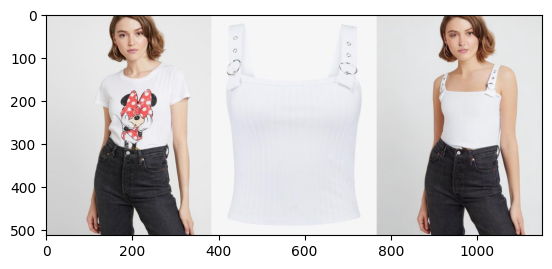

In [98]:
from PIL import Image
img=Image.open('./output/vitonhd-512/unpaired/12562_00.jpg')

import matplotlib.pyplot as plt
plt.imshow(img)

(-0.5, 767.5, 1023.5, -0.5)

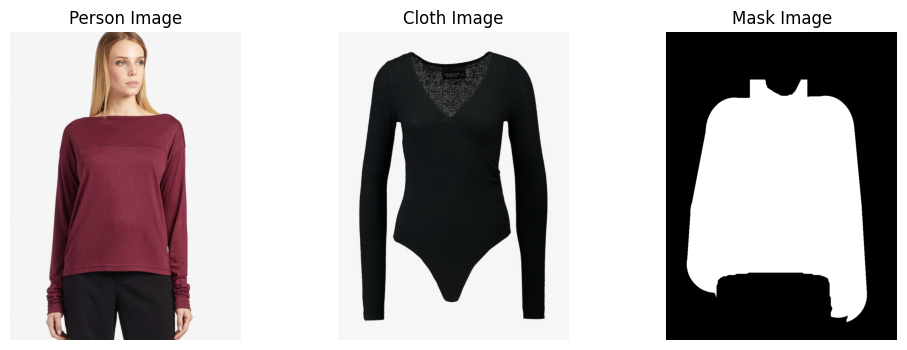

In [25]:
from PIL import Image

person_image = Image.open(f"/kaggle/input/viton-hd-dataset/test/image/{person_img}").convert("RGB")
cloth_image = Image.open(f"/kaggle/input/viton-hd-dataset/test/cloth/{cloth_img}").convert("RGB")
mask_image = Image.open(f"/kaggle/input/viton-hd-dataset/test/agnostic-mask/{mask_img.replace('.jpg', '_mask.png')}").convert("L")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(person_image)
plt.title("Person Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cloth_image)
plt.title("Cloth Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask_image, cmap='gray')
plt.title("Mask Image")
plt.axis('off')

In [ ]:
# # Replace <path> with your actual data root and output directory paths
# !CUDA_VISIBLE_DEVICES=0 python inference.py \
# --dataset vitonhd \
# --data_root_path /kaggle/input/viton-hd-dataset \
# --output_dir ./output \
# --dataloader_num_workers 8 \
# --batch_size 8 \
# --seed 555 \
# --mixed_precision no \
# --allow_tf32 \
# --repaint \
# --eval_pair

2025-06-11 03:13:29.903172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749611610.125212     127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749611610.187151     127 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
config.json: 100%|█████████████████████████████| 547/547 [00:00<00:00, 4.50MB/s]
diffusion_pytorch_model.safetensors: 100%|████| 335M/335M [00:01<00:00, 250MB/s]
config.json: 100%|█████████████████████████████| 748/748 [00:00<00:00, 4.77MB/s]
An error occurred while trying to fetch booksforcharlie/stable-diffusion-inpainting: booksforcharlie/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safe